## Описание проекта

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:<br>
    - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
    - Контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

Подключение необходимых библиотек.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

Получим информацию с помощью загрузчика данных.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Посмотрим на общую информацию по талице, а также на размер выборки.

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


В нашей таблице 7591 строка.

Построим гистограмму распределения возрастов по нашей выборке.

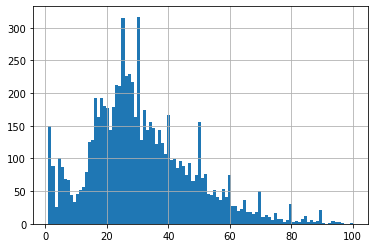

In [4]:
labels['real_age'].hist(bins=100)

Видно, что в наших данных преобладают люди от 15 до 40 лет. Далее идет планомерный спад. Также стоит отметитьчто достаточно большое картинок с детьми (до 10 лет). Это все говорит, что наша будущая модель будет хорошо распозновать данные категории граждан. Чем дальше от этих значений, тем менее точно будет прогнозироваться возраст.

Получим часть наших признаков и целевые признаки к ним.

In [5]:
features, target = next(train_gen_flow)

In [6]:
features.shape

(32, 224, 224, 3)

Построим как устроен датасет. Для этого выведем первых 10 людей.

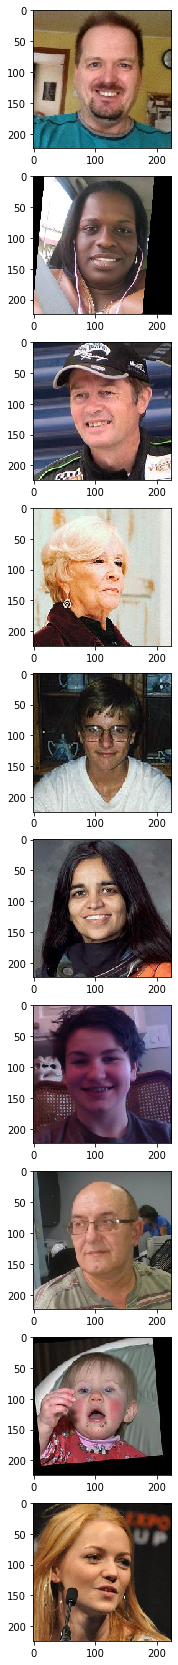

In [7]:
count_pics = 10

fig, axes = plt.subplots(nrows=count_pics, ncols=1)
fig.set_figwidth(30)
fig.set_figheight(30)
for i in range(count_pics):
    axes[i].imshow(features[i])

### Вывод

На данном этапе мы посмотрели на данные. Посмотрели на распределение возраста в нашей выборке и установили на более часто встречаемые категории. После чего наглядно ознакомились с датасетом, выведя 10 картинок из него. Теперь мы понимаем более четко с чем мы имеем дело.

## Обучение модели

Построим и обучим свёрточную нейронную сеть на датасете с фотографиями людей. Для этого используем архитектуру ResNet50. Наша цель - добиться значения MAE на тестовой выборке не больше 8. В качестве функции потерь возьмем MSE.

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
 

datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255) 
 
def load_train(path):
    labels = pd.read_csv(path + '/labels.csv')
    
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    
    return train_gen_flow 


def load_test(path):
    labels = pd.read_csv(path + '/labels.csv')
    
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    
    return test_gen_flow


def create_model(input_shape):
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet', 
        include_top=False)
    backbone.trainable = True
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(lr=0.0005)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2)
    
    return model

```

```

2021-04-11 00:07:47.127060: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2021-04-11 00:07:47.129112: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2021-04-11 00:07:48.242552: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-04-11 00:07:48.931492: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2021-04-11 00:07:48.931581: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-04-11 00:07:48.931646: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-04-11 00:07:48.933992: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-04-11 00:07:48.934507: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2021-04-11 00:07:48.937140: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2021-04-11 00:07:48.938531: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2021-04-11 00:07:48.938614: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2021-04-11 00:07:48.942597: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2021-04-11 00:07:48.943075: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-04-11 00:07:48.951516: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1999990000 Hz
2021-04-11 00:07:48.952246: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x518d4e0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-04-11 00:07:48.952277: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-04-11 00:07:49.090237: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5213500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2021-04-11 00:07:49.090285: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2021-04-11 00:07:49.092562: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2021-04-11 00:07:49.092647: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-04-11 00:07:49.092676: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-04-11 00:07:49.092730: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-04-11 00:07:49.092771: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2021-04-11 00:07:49.092824: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2021-04-11 00:07:49.092860: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2021-04-11 00:07:49.092887: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2021-04-11 00:07:49.096894: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2021-04-11 00:07:49.096981: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-04-11 00:07:49.457004: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-04-11 00:07:49.457061: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2021-04-11 00:07:49.457075: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2021-04-11 00:07:49.461411: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/10
2021-04-11 00:08:04.051530: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-04-11 00:08:04.389363: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 69s - loss: 200.9653 - mae: 10.5168 - val_loss: 537.4402 - val_mae: 18.1256
Epoch 2/10
178/178 - 41s - loss: 99.8631 - mae: 7.6150 - val_loss: 306.5103 - val_mae: 13.0186
Epoch 3/10
178/178 - 41s - loss: 63.5051 - mae: 6.1125 - val_loss: 424.2551 - val_mae: 15.5039
Epoch 4/10
178/178 - 41s - loss: 41.0645 - mae: 4.9523 - val_loss: 168.8179 - val_mae: 10.1169
Epoch 5/10
178/178 - 41s - loss: 27.3533 - mae: 4.0147 - val_loss: 102.0250 - val_mae: 7.6177
Epoch 6/10
178/178 - 41s - loss: 20.8037 - mae: 3.5326 - val_loss: 148.6344 - val_mae: 9.4831
Epoch 7/10
178/178 - 41s - loss: 16.3057 - mae: 3.1288 - val_loss: 93.6219 - val_mae: 7.3049
Epoch 8/10
178/178 - 41s - loss: 12.8073 - mae: 2.7513 - val_loss: 74.9251 - val_mae: 6.6103
Epoch 9/10
178/178 - 41s - loss: 9.9638 - mae: 2.4007 - val_loss: 70.9065 - val_mae: 6.4998
Epoch 10/10
178/178 - 41s - loss: 10.3813 - mae: 2.4705 - val_loss: 80.2036 - val_mae: 6.7043
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 80.2036 - mae: 6.7043
Test MAE: 6.7043

```

### Вывод

Мы написали 4 функции, которые используются в GPU-тренажере для обучения модели. В результате обучения мы получили значение MAE 6.7043, что удовлетворяет нашему условию успешности эксперимента (<=8). Согласно приведенной статье, лучшим результатом для данного набора данных является MAE = 5.4. Наше значение довольно близко.

## Анализ обученной модели

Наша модель показала высокий результат MAE=6,704. Учитывая то, что мы использовали стандартную архитектуру ResNet в Keras с 50 слоями и предобученную на ImageNet сети, такой результат можно получить практически "из коробки". Это показывает насколько эффективными могут быть сверточные нейронные сети при небольших затратах ресурсов и времени.